In [1269]:
%run evaluation.ipynb

In [1270]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [1271]:
# 569 samples
# 30  features
data = pd.read_csv('data.csv')

## droping nan
data = data.drop(columns=["id", "Unnamed: 32"])


In [1272]:
data.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [1273]:
#split data
X = data.sample(frac=0.7,random_state = 42)
labels_train = X['diagnosis'].map({'M': 0, 'B': 1}).to_numpy()


rest_of_data = data.drop(X.index)
X = X.drop(columns=["diagnosis"])

X_val = rest_of_data.sample(frac=0.5,random_state = 42)
labels_val = X_val['diagnosis'].map({'M': 0, 'B': 1}).to_numpy()


X_test = rest_of_data.drop(X_val.index)
labels_test = X_test['diagnosis'].map({'M': 0, 'B': 1}).to_numpy()

X_val = X_val.drop(columns=["diagnosis"])
X_test = X_test.drop(columns=["diagnosis"])


In [1274]:
def normalize(X):
    mean = np.mean(X, axis=0)               # axis=0 --> works col. by col.
    std = np.std(X, axis=0)

    std[std == 0] = 1.0  

    return (X - mean) / std                 #for each row in x , we subtract mean of each feaure and / by std


In [1275]:
def calculate_euclidean(a, b):
    return np.sqrt(np.sum((a - b) ** 2))


In [1276]:
def get_intial_centroids_random(X, k):
    n = X.shape[0]
    indices = np.random.choice(n, k, replace=False)
    return X[indices]


def get_intial_centroids_kmeansPP(X, k):
    n = X.shape[0]
    centroids = []
    chosen_indices = set()

    # first centroid
    idx = np.random.randint(n)
    centroids.append(X[idx])
    chosen_indices.add(idx)

    for _ in range(1, k):

        distances = []
        
        for x in X:
            min_dist = np.inf
            for c in centroids:
                dist = np.sum((x - c) ** 2)
                if dist < min_dist:
                    min_dist = dist
            distances.append(min_dist)  

        distances = np.array(distances)

        # choose new centroids with a prob. propetional to distnace
        # prob. to choose a certain point as centroid inc. as dist. bet. it and other centroids inc.
        probs = distances / np.sum(distances)        # array  of size n with each prob. of choosing this point as next center

        # sample until we get a new index
        while True:
            idx = np.random.choice(n, p=probs)
            if idx not in chosen_indices:
                break

        centroids.append(X[idx])
        chosen_indices.add(idx)

    return np.array(centroids)










In [1277]:
def assign_clusters(X, centroids):
    no_of_points = X.shape[0]
    labels = np.zeros(no_of_points, dtype=int) #size = no. of poits

    #calc. min. dist. for each point
    for i in range(no_of_points):
        distances = []
        for c in centroids:
            distances.append(calculate_euclidean(X[i], c))

        # will assign point to cluster with min dist.
        labels[i] = np.argmin(distances)        #assigning indices
    return labels

def update_centroids(X, labels, k):
    centroids = np.zeros((k, X.shape[1]))

    for cluster in range(k):
        points = X[labels == cluster]

        # avoid empty cluster
        if len(points) > 0:
            centroids[cluster] = np.mean(points, axis=0)

    return centroids

def compute_inertia(X, labels, centroids):
    inertia = 0.0
    for i in range(len(X)):
        inertia += np.sum((X[i] - centroids[labels[i]]) ** 2)
    return inertia


In [1278]:
def kmeans(X, k, max_iters, tolerance,centroids):

    inertia_history = []

    for i in range(max_iters):
        labels = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, labels, k)

        inertia = compute_inertia(X, labels, new_centroids)
        inertia_history.append(inertia)

        # convergence check
        if i != 0:
            if (inertia_history[i-1] - inertia_history[i]) < tolerance:
                break

        centroids = new_centroids

    return labels,inertia_history


In [1279]:
X = X.to_numpy()
X = normalize(X)
X_val = X_val.to_numpy()
X_val = normalize(X_val)
X_test = X_test.to_numpy()
X_test = normalize(X_test)


In [1280]:
# type: ignore

#try out diff tolerances
k = 2
tolerances = [ 1e-4,1e-3,1e-2 ]
max_iterations = [20,50,100]
centroids = get_intial_centroids_random(X_val,k)
correctness = []
for tol in tolerances:
    labels_rand,_ = kmeans(X_val,k,100,tol,centroids)
    score = adjusted_rand_index(labels_val,labels_rand)
    correctness.append(score)
index_t = np.argmax(correctness)   
print(f"best tolerance value = {tolerances[index_t]}") 


correctness = []
for iter in max_iterations:
    labels_rand,_ = kmeans(X_val,k,iter,1e-4,centroids)
    score = adjusted_rand_index(labels_val,labels_rand)
    correctness.append(score)
index_it = np.argmax(correctness)   
print(f"best iterations value = {max_iterations[index_it]}") 



	


best tolerance value = 0.0001
best iterations value = 20


In [1281]:
# type: ignore

# compare between kmeans++ and random intialization using best tol,iterations
centroids = get_intial_centroids_random(X_val,k)
labels_rand,_ = kmeans(X_val,k,max_iterations[index_it],tolerances[index_t],centroids)
print(f"ARI score for random centroids {adjusted_rand_index(labels_val,labels_rand)}")
centroids_PP = get_intial_centroids_kmeansPP(X_val,k)
labels_PP,_ = kmeans(X_val,k,max_iterations[index_it],tolerances[index_t],centroids_PP)
print(f"ARI score for kmeans++ centroids {adjusted_rand_index(labels_val,labels_PP)}")

ARI score for random centroids 0.6207622350954781
ARI score for kmeans++ centroids 0.6585143234968593


In [1282]:
#type: ignore

# Expirment 1 Kmeans on original data

k_values = range(2, 11)

inertias = []
silhouettes = []
gaps = []

B = 10  # number of reference datasets for gap statistic

print("k | Inertia     | Silhouette | Gap")
print("--|-------------|------------|------")

for k in k_values:
    labels, inertia_history = kmeans(X_val, k,100,1e-4,centroids_PP)
    inertia_k = float(inertia_history[-1])
    inertias.append(inertia_k)

    sil_k = float(silhouette_score(X_val, labels))
    silhouettes.append(sil_k)


    log_w_random = []

    for _ in range(B):
        X_rand = np.random.uniform(
            low=np.min(X_val, axis=0),
            high=np.max(X_val, axis=0),
            size=X_val.shape
        )

        _, inertia_hist_rand = kmeans(X_rand, k, 100, 1e-4,centroids_PP)
        log_w_random.append(np.log(float(inertia_hist_rand[-1])))

    gap_k = float(np.mean(log_w_random) - np.log(inertia_k))
    gaps.append(gap_k)

    print(f"{k:>1} | {inertia_k:11.2f} | {sil_k:10.4f} | {gap_k:6.4f}")
    convergence_speed = len(inertia_history) - 1
    print(f"algorithm converged in {convergence_speed} iterations")


k | Inertia     | Silhouette | Gap
--|-------------|------------|------
2 |     1728.10 |     0.3462 | 1.2257
algorithm converged in 5 iterations
3 |     1430.42 |     0.3371 | 1.3911
algorithm converged in 8 iterations
4 |     1289.06 |     0.2671 | 1.4986
algorithm converged in 8 iterations
5 |     1190.41 |     0.1994 | 1.5705
algorithm converged in 7 iterations
6 |     1120.45 |     0.2093 | 1.6297
algorithm converged in 9 iterations
7 |     1058.94 |     0.2208 | 1.6911
algorithm converged in 9 iterations
8 |     1049.14 |     0.1907 | 1.6936
algorithm converged in 8 iterations
9 |     1049.14 |     0.1907 | 1.7011
algorithm converged in 8 iterations
10 |     1049.14 |     0.1907 | 1.6972
algorithm converged in 8 iterations


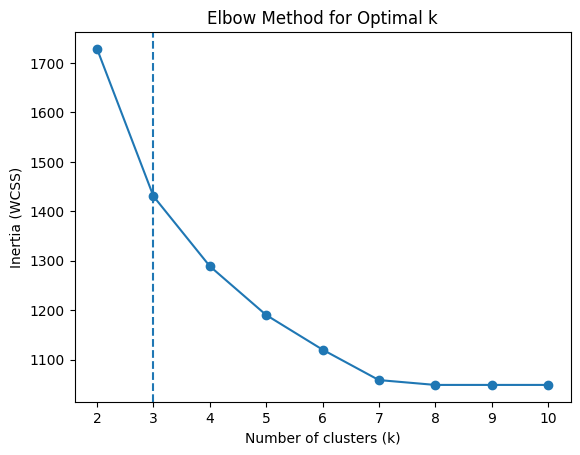

In [1283]:


optimal_k = 3  # change if your chosen k is different

plt.figure()
plt.plot(k_values, inertias, marker='o')
plt.axvline(optimal_k, linestyle='--')
plt.xlabel("Number of clusters (k)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow Method for Optimal k")
plt.show()


[2 2 0 2 2 1 2 1 0 2 2 2 2 0 2 1 2 2 2 0 2 2 2 0 2 2 1 2 0 1 0 0 2 2 2 2 0
 2 0 2 1 2 2 2 1 2 0 2 0 1 1 0 2 0 2 0 2 2 2 1 2 2 2 1 2 2 0 2 2 1 0 1 1 2
 1 1 2 2 2 2 2 2 0 1 0 1]


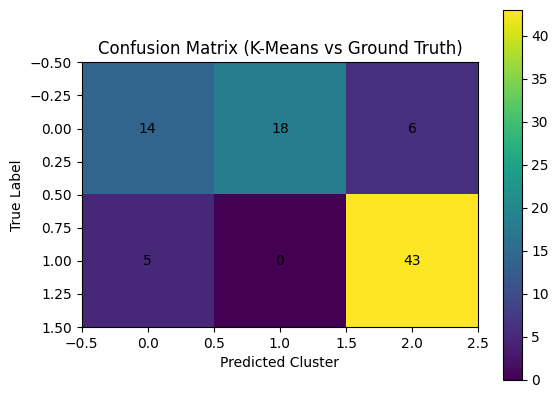

In [1284]:
#type: ignore
labels, _ = kmeans(X_val, optimal_k ,max_iterations[index_it],tolerances[index_t],centroids_PP)
cm = confusion_matrix(labels_val, labels)
print(labels)
plt.figure()
plt.imshow(cm)
plt.colorbar()
plt.xlabel("Predicted Cluster")
plt.ylabel("True Label")
plt.title("Confusion Matrix (K-Means vs Ground Truth)")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.show()
